In [ ]:
from keras.datasets import cifar10
(fx_train, fy_train), (fx_test, fy_test) = cifar10.load_data()
fx_val, fy_val = fx_train[:5000], fy_train[:5000] # creating validation dataset (to permit better interpretation of learning graphs and an accurate final test score)
fx_train, fy_train = fx_train[5000:], fy_train[5000:]

import cv2
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.colors as clrs

170508288/170498071 [==============================] - 4s 0us/step


**Exercise 1 - Image processing: adaptive threshold**

Original Image


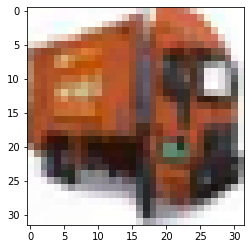

Original Image in grayscale


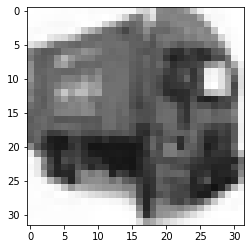

Image with thresholding


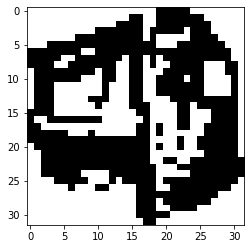

In [ ]:
# Exercise One - Image processing: conversion to black and white and thresholding
ImageExOne = fx_train[2]
print("Original Image")
plt.imshow(cv2.cvtColor(ImageExOne, cv2.COLOR_RGB2BGR))
plt.show()
grayImageExOne = cv2.cvtColor(ImageExOne,cv2.COLOR_BGR2GRAY) # image is converted to grayscale because thresh_binary can't be applied to colour images
print("Original Image in grayscale")
plt.imshow(grayImageExOne, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.show()
threshold = cv2.adaptiveThreshold(grayImageExOne,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,17,2)
# The function makes pixels higher than a certain value black and the others white so that no grey elements remain.
# Thus, noise is removed from the image and important features are easier to detect.
# Adaptive thresholding means that there is no absolute threshold which determines whether a certain pixel will be set to black,
# but instead it depends on the value of the pixels surrounding a pixel whether it will be black or white in the output.
# Thus the edges become more visible in the result, whereas areas where the colour is the same will not be entirely black in the output.
print("Image with thresholding")
plt.imshow(threshold, cmap='gray')

One hot encoding the categories

In [ ]:
fy_train=tf.keras.utils.to_categorical(fy_train, num_classes=10)
fy_test=tf.keras.utils.to_categorical(fy_test, num_classes=10)
fy_val=tf.keras.utils.to_categorical(fy_val, num_classes=10)

fx_train, fx_test, fx_val = fx_train / 255.0, fx_test / 255.0 , fx_val / 255.0  # Divide pixels by 255.0 to normalize them / every value between 0 and 1

Define different optimizers

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True) # Source: https://stackoverflow.com/questions/37213388/keras-accuracy-does-not-change

adam =tf.keras.optimizers.Adam(learning_rate=0.001)

The images in the dataset are in colour, so there are 3 dimensions/ color channels.
For the MLP the input is flattened so it does not contain spatial information (which pixel is located where in relation to each other).

**Exercise 2 - MLP: Model Construction and Training**

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
model.add(tf.keras.layers.Dense(512,input_dim=2,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(200, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation='softmax'))

print(model.summary())

model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['categorical_crossentropy', 'accuracy'])
history=model.fit(fx_train,fy_train, batch_size=50, epochs=32, validation_data=(fx_val, fy_val), shuffle=False, verbose=1)

# Adam optimizer was worse than SGD (final test accuracy about 42%).

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               205000    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2

In [ ]:
# Define Function to display Learning Curves
import matplotlib.pyplot as plt
import pandas as pd
def history_plots(history):

  plt.plot(history.epoch, history.history['accuracy'])
  plt.plot(history.epoch, history.history['val_accuracy'])
  plt.title('Accuracy and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Accuracy', 'Validation Accuracy'])
  plt.show()

  plt.plot(history.epoch, history.history['loss'])
  plt.plot(history.epoch, history.history['val_loss'])
  plt.title('Loss and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(["Loss", "Validation Loss"])
  plt.show()

  # Define Function to show 9 random images with predicted and correct label
categories=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
def predict_random_images(x_data, y_data, model):
    w = 10
    h = 10
    fig = plt.figure(figsize=(30, 30))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        imagenumber = random.randint(0,10000)
        image = x_data[imagenumber]
        predictedclass = categories[np.argmax(model.predict(x_data)[imagenumber], axis=-1)]
        title = 'Model predicted: ' + str(predictedclass) + '\n Correct class: ' + str(categories[np.argmax(y_data[imagenumber])])
        fig.add_subplot(rows, columns, i).set_title(title)
        plt.imshow(image)
    plt.show()



MLP Evaluation - Learning curves, 9 random images, final test accuracy

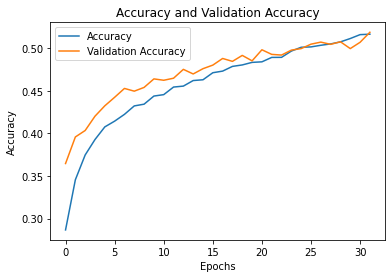

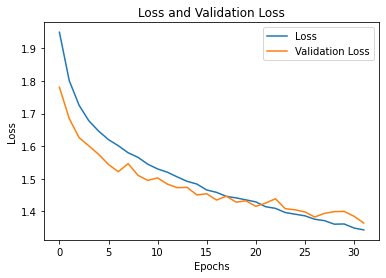

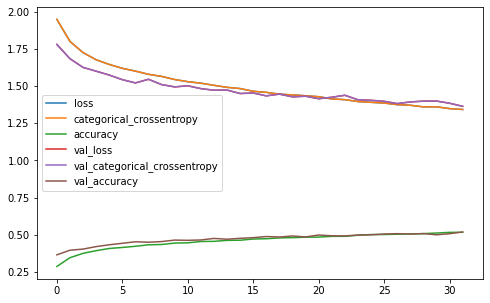

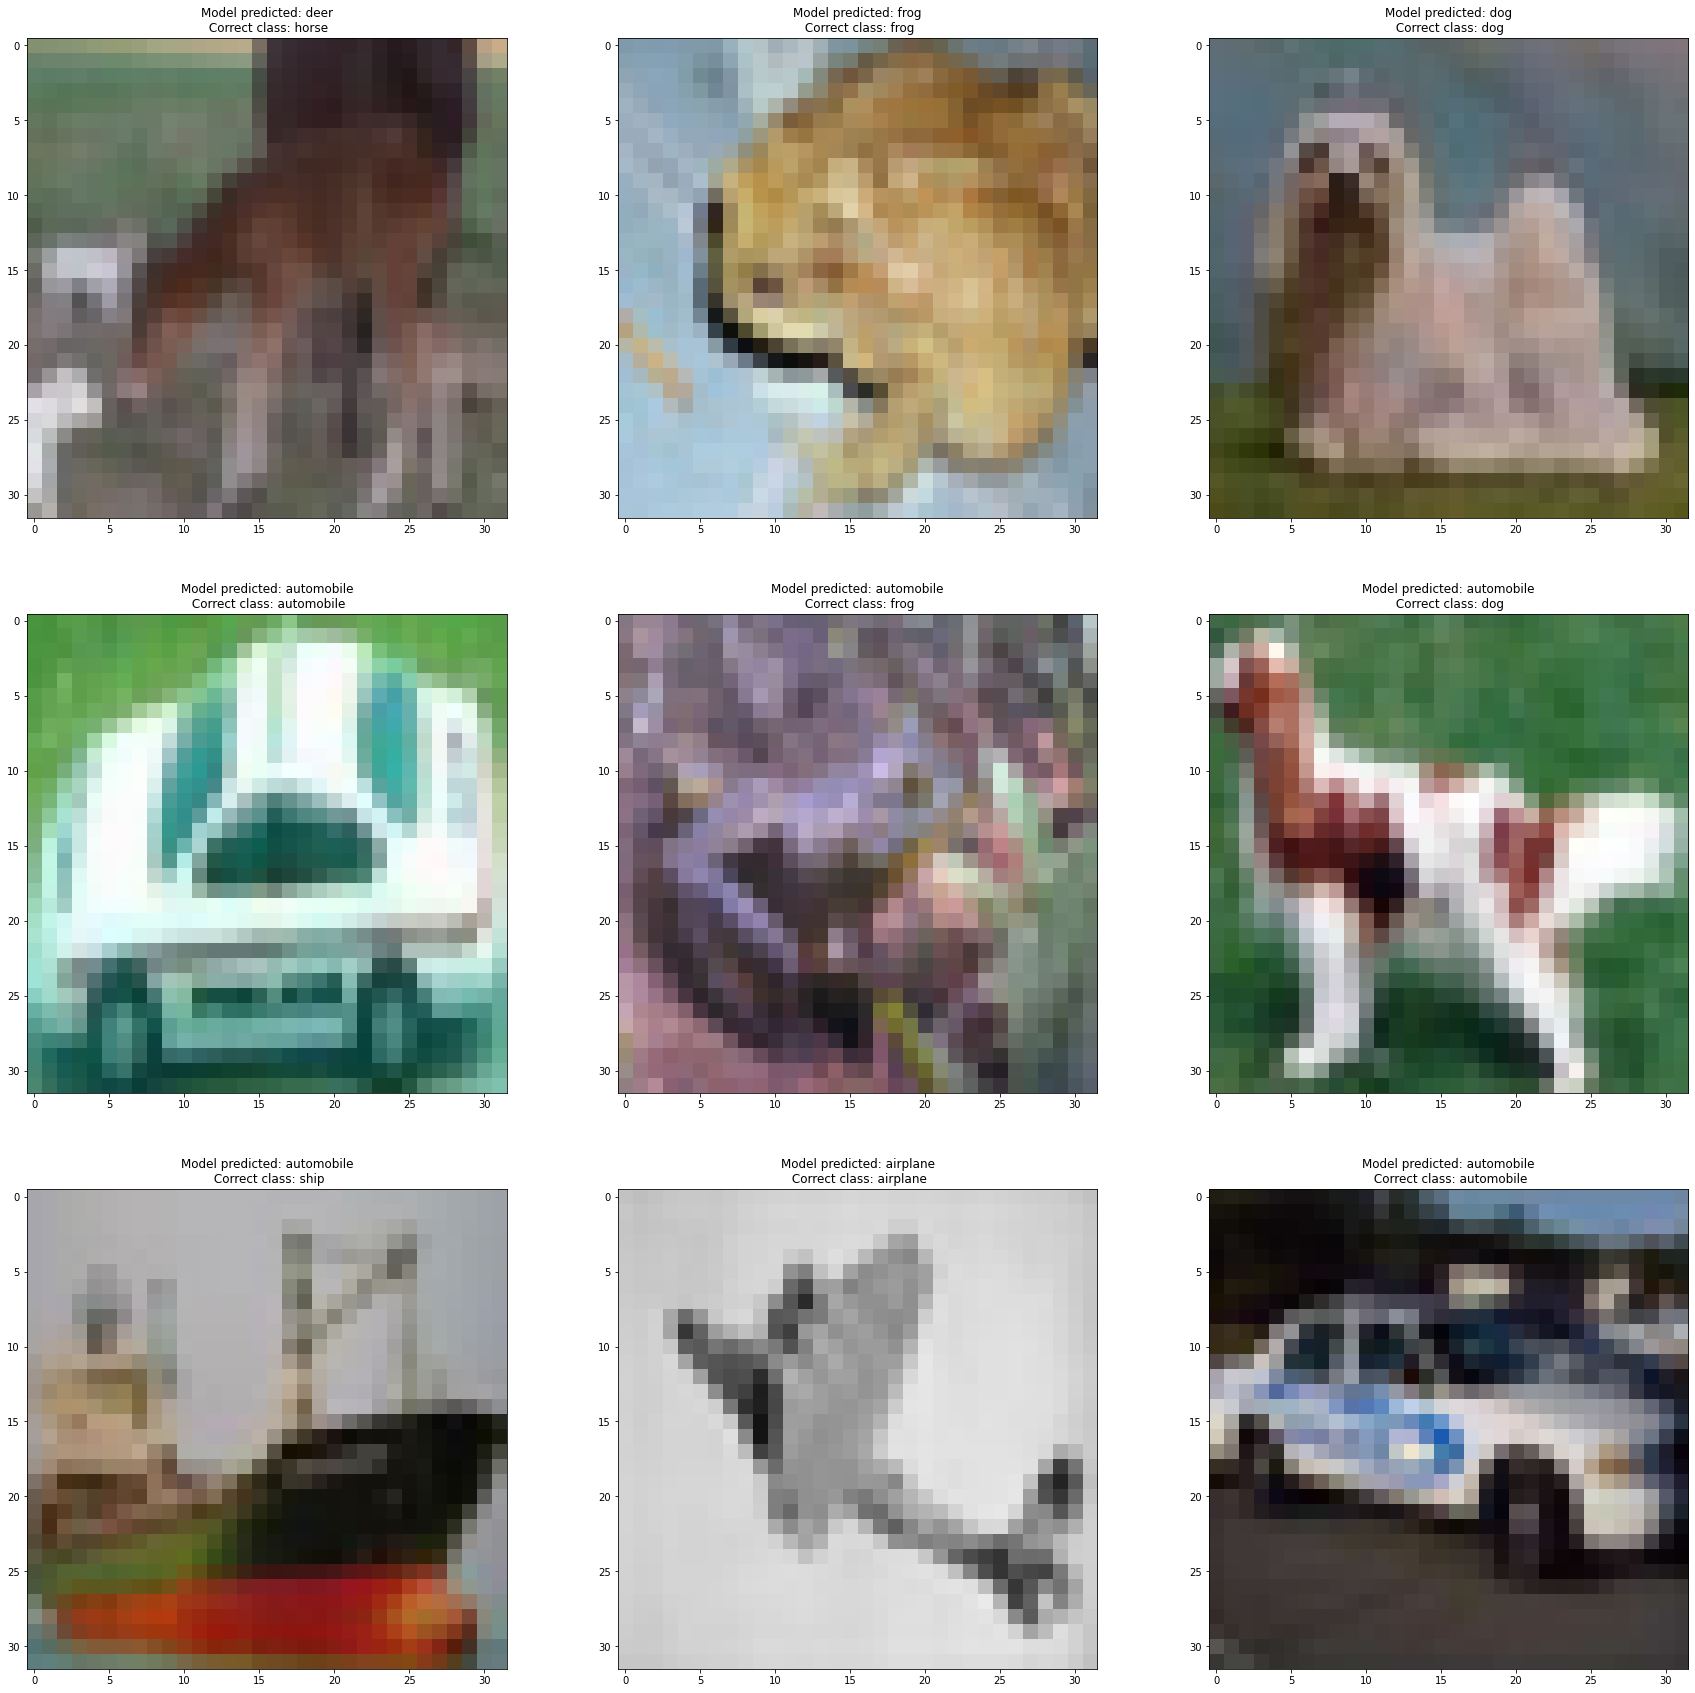

313/313 [==============================] - 1s 3ms/step - loss: 1.3732 - categorical_crossentropy: 1.3732 - accuracy: 0.5117
MLP Test Accuracy: 51.17%


In [ ]:
# Show MLP Learning Curves
history_plots(history)

pd.DataFrame(history.history).plot(figsize=(8,5)) #Source: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
plt.show()

# Show MLP 9 random images
predict_random_images(fx_test,fy_test,model)

# Show final test accuracy
eval = model.evaluate(fx_test, fy_test)
acc = eval[2]*100
print("MLP Test Accuracy: "+ str(round(acc,2)) + "%")

The model takes a long time (many epochs) to train. The acccuracy is not entirely bad, but it took some time to find out the right hyperparameters. While 50 % accuracy is way better than random guessing, and the learning curves show that some learning does take place, it is still not optimal. Moreover, the learning curves show that the model will overfit soon.

**Exercise 3 - CNN - Model Setup and Training**

In [ ]:
# Exercise 3 - CNN - Model Setup and Training

model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model2.add(tf.keras.layers.Conv2D(32,(3,3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))

model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Dropout(0.2))

model2.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))

model2.add(tf.keras.layers.Dropout(0.3))

model2.summary()

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dense(10, activation='softmax'))

model2.summary()

model2.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2=model2.fit(fx_train, fy_train, validation_data=(fx_val, fy_val), epochs=12, verbose=2)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)        

CNN Evaluation - Learning Curve, predict 9 random images

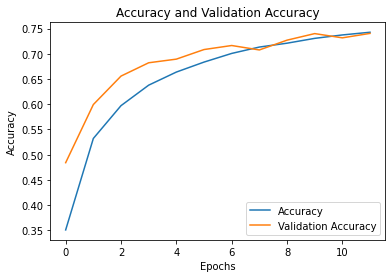

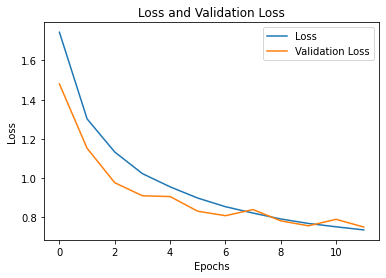

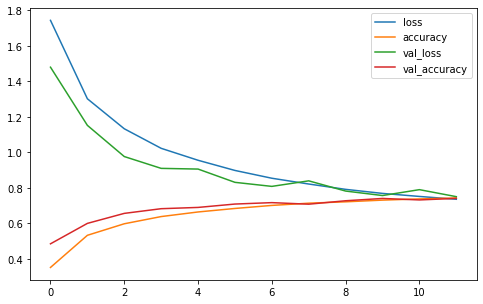

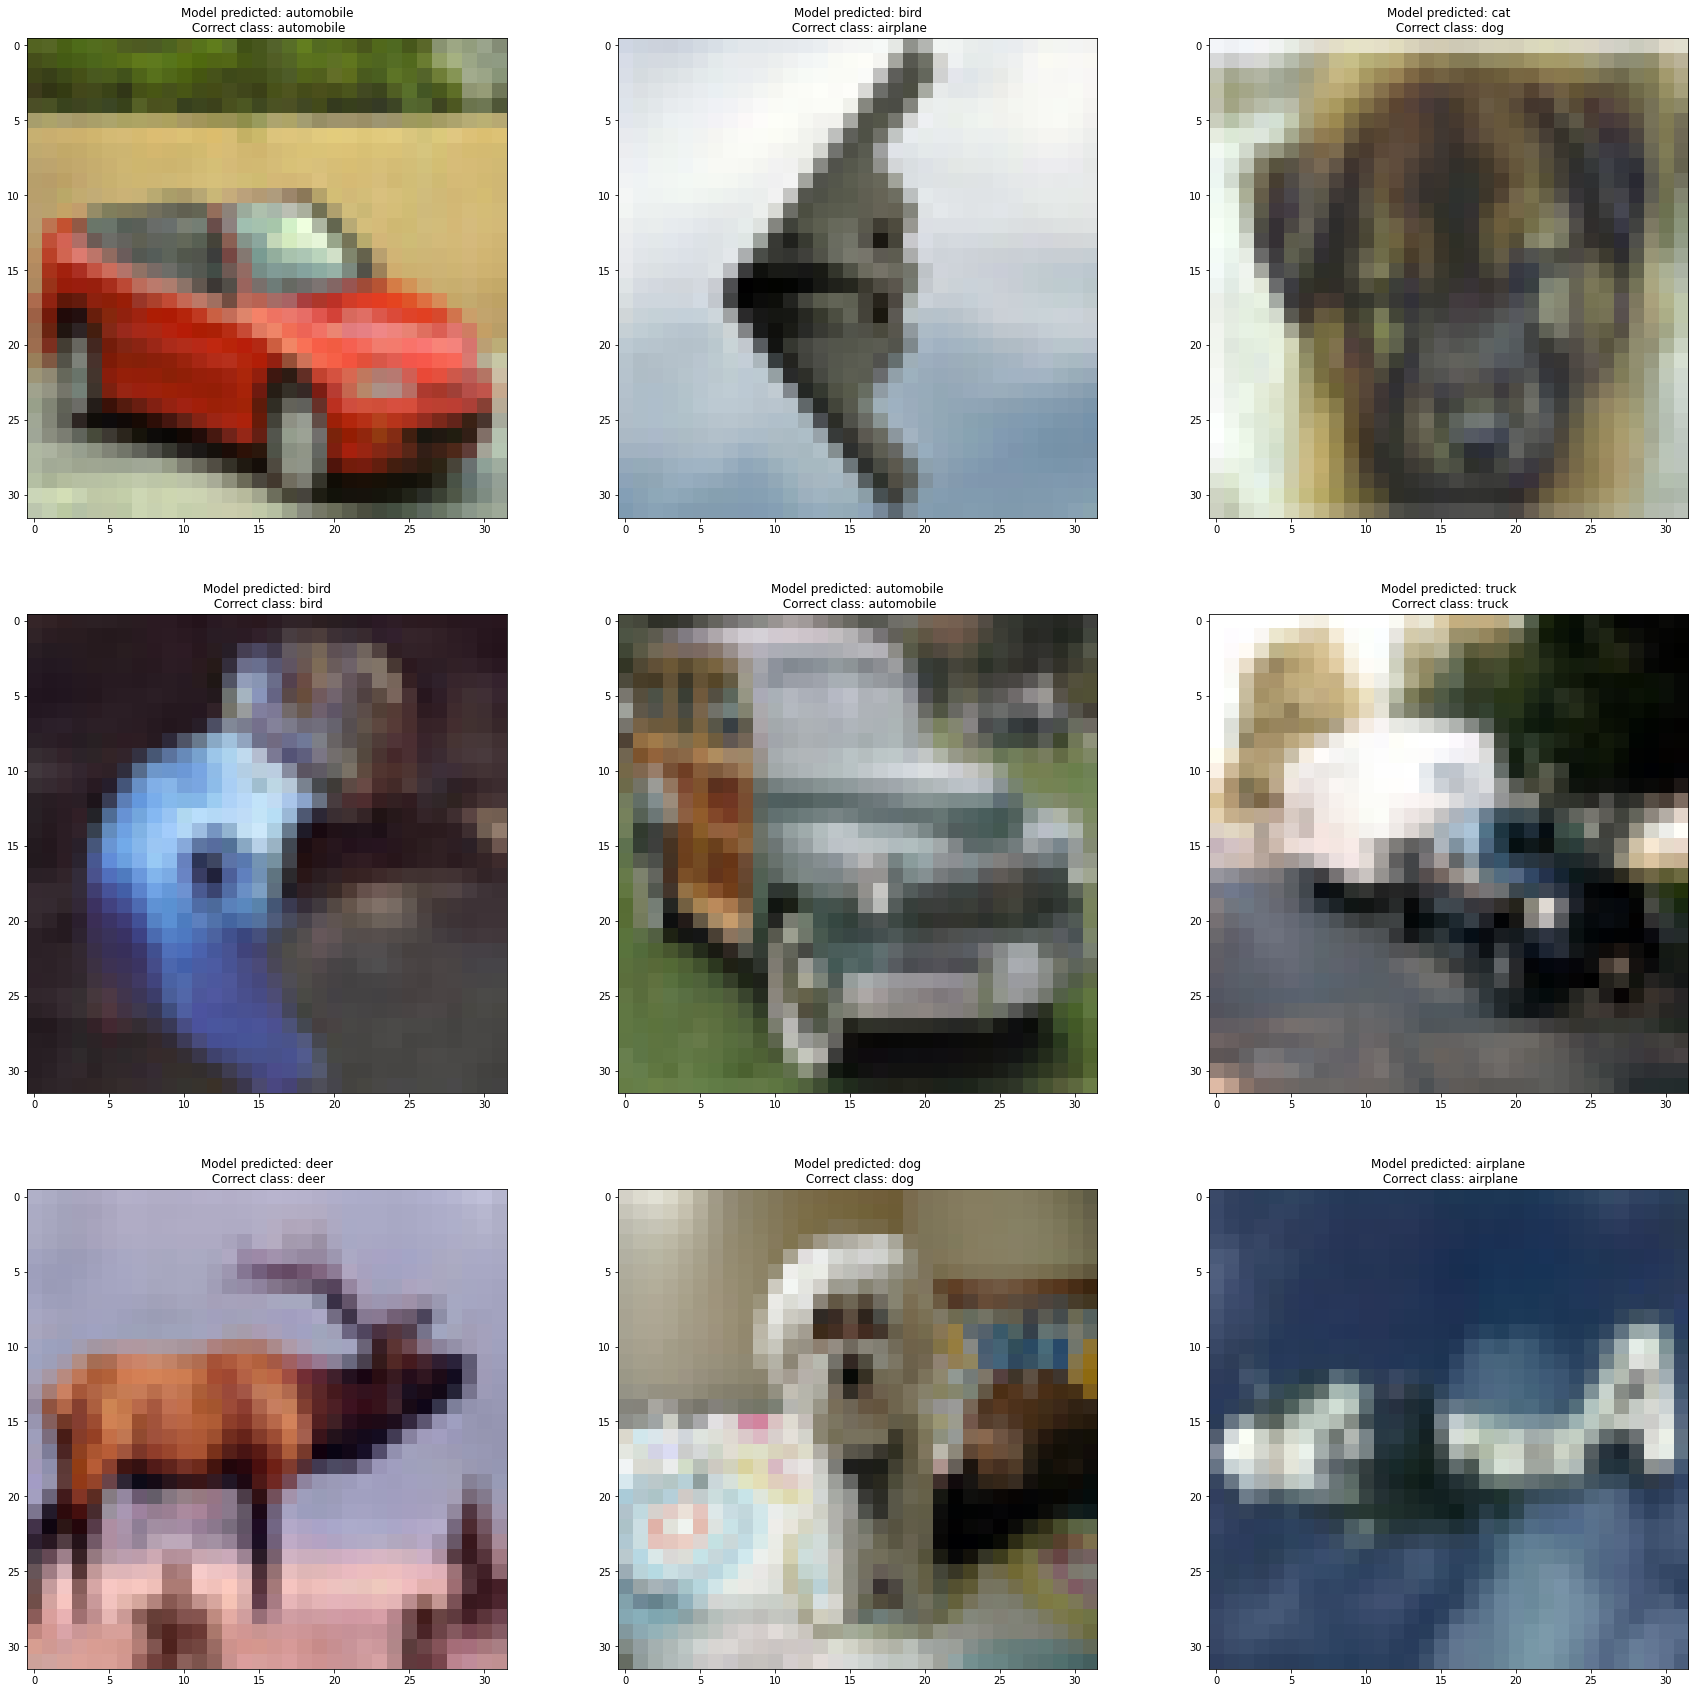

313/313 [==============================] - 1s 3ms/step - loss: 0.7621 - accuracy: 0.7403
CNN Test Accuracy: 74.03%


In [ ]:
history_plots(history2)
pd.DataFrame(history2.history).plot(figsize=(8,5)) #Source: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
plt.show()
predict_random_images(fx_test,fy_test,model2)

eval2 = model2.evaluate(fx_test, fy_test)
acc2 = eval2[1]*100
print("CNN Test Accuracy: "+ str(round(acc2,2)) + "%")

**Final Assessment and comparison of the models**
The multilayer perceptron takes much longer to train (more epochs) and achieves lower accuracy than the CNN (only about 50 percent).
The CNN is faster in training and reaches about 75% accuracy. However the difficulty with CNNs is that they are prone to overfitting, which is why I used some Dropout layers. In this case the MLP overfits more and takes longer to train. It appears that MLPs do not work that well for image classification problems.